<h1>Predicting General Election Voter Turnout</h1>
<h2>Optimus Predictive Modeling Exercise</h2>
<p><b>Exercise:</b> Pretend it is may 2014 and we want to predict the voter turnout for the general election in November.</p>
<p><b>Voter History:</b> Fields prefixed with vh denote voter history where the following two digits refer to the year of the election and the final letter p or g indicate primary or general election. A value of <b>1</b> indicates that the individual voted in that election and a value of <b>0</b> indicates that the voter did not show up.</p>



# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from umap import UMAP
import xgboost as xgb
from statistics import mode
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

Using TensorFlow backend.


<h1>Read and Display Data</h1>
<p>A lot of this data is categorical so it will be a good idea to encode the data numerically. The data also has some missing values, so we will need to impute the data.</p>

In [2]:
voter_file = 'data/voterfile/voterfile.csv'
df = pd.read_csv(voter_file)
df.head(3)

,optimus_id,age,party,ethnicity,maritalstatus,dwellingtype,income,education,cd,dma,...,intrst_musical_instruments_in_hh,donates_to_liberal_causes,donates_to_conservative_causes,home_owner_or_renter,g08_precinct_turnout,g10_precinct_turnout,g12_precinct_turnout,p08_precinct_turnout,p10_precinct_turnout,p12_precinct_turnout
0,861681,69.0,Republican,European,Married,Single Family Dwelling Unit,75k-125k,Bach Degree - Extremely Likely,4.0,LAS VEGAS DMA (EST.),...,NaN,NaN,NaN,Likely Homeowner,0.56,0.54,0.75,0.17,0.32,0.24
1,1084850,20.0,American Independent,European,NaN,NaN,Unknown,NaN,2.0,RENO DMA (EST.),...,NaN,NaN,NaN,NaN,0.84,0.82,0.92,0.47,0.62,0.47
2,644435,28.0,Non-Partisan,European,NaN,NaN,Unknown,NaN,3.0,LAS VEGAS DMA (EST.),...,NaN,NaN,NaN,NaN,0.49,0.34,0.70,0.04,0.09,0.06


In [3]:
list(df.columns)

['optimus_id',
 'age',
 'party',
 'ethnicity',
 'maritalstatus',
 'dwellingtype',
 'income',
 'education',
 'cd',
 'dma',
 'occupationindustry',
 'vh14p',
 'vh12g',
 'vh12p',
 'vh10g',
 'vh10p',
 'vh08g',
 'vh08p',
 'vh06g',
 'vh06p',
 'vh04g',
 'vh04p',
 'vh02g',
 'vh02p',
 'vh00g',
 'vh00p',
 'net_worth',
 'petowner_dog',
 'intrst_nascar_in_hh',
 'intrst_musical_instruments_in_hh',
 'donates_to_liberal_causes',
 'donates_to_conservative_causes',
 'home_owner_or_renter',
 'g08_precinct_turnout',
 'g10_precinct_turnout',
 'g12_precinct_turnout',
 'p08_precinct_turnout',
 'p10_precinct_turnout',
 'p12_precinct_turnout']

<h1>Correlation Heatmap: Primary and General Election Voting History</h1>

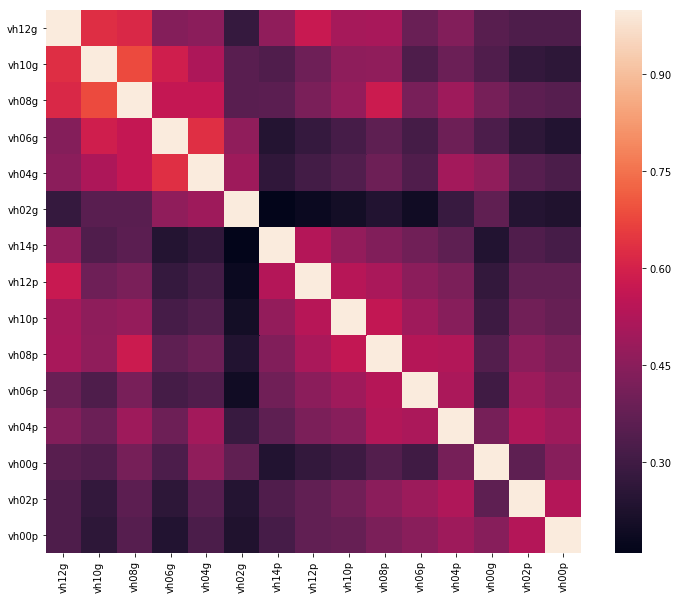

In [4]:
fig,ax = plt.subplots(1,1)
sns.heatmap(
df[[
 'vh12g',
 'vh10g',
 'vh08g',
 'vh06g',
 'vh04g',
 'vh02g',
 'vh14p',  
 'vh12p', 
 'vh10p',
 'vh08p',
 'vh06p', 
 'vh04p',
 'vh00g',
 'vh02p',
 'vh00p',]].corr(), ax=ax)

fig.set_size_inches(12,10)

<h1>Analysis:</h1>
<p>In the above graph we are comparing the correlation of voter turn out between election years. The closer a square is to white, the more closely correlated the two voting years are.</p>
<p>For example, you can see that a white diagonal is displayed across the graph. This is because there is a perfect correlation between a given election's voting history with itself (obviously).</p>
<p>This graph suggests that there exists a very low correlation between voter turnout for primary elections and voter turn out for general elections. Since we are only concerned with general election turnout, we can safely remove primary election information from the dataset.</p>

# Preprocessing the Data 

In [5]:
# remove optimus ID column from data
del df['optimus_id']

# remove primary election turnout data 
for header in df.columns:
    if header[-1] == 'p':
        del df[header]

In [6]:
# identify all categorical columns
categorical_columns = [
 'party',
 'ethnicity',
 'maritalstatus',
 'dwellingtype',
 'income',
 'education',
 'cd',
 'dma',
 'occupationindustry',
 'net_worth',
 'petowner_dog',
 'intrst_nascar_in_hh',
 'intrst_musical_instruments_in_hh',
 'donates_to_liberal_causes',
 'donates_to_conservative_causes',
 'home_owner_or_renter',
]

In [7]:
# turn categorical columns into numerical codes
for header in categorical_columns:
    df[header] = df[header].astype('category').cat.codes

In [8]:
# display data 
df.head(3)

,age,party,ethnicity,maritalstatus,dwellingtype,income,education,cd,dma,occupationindustry,...,intrst_musical_instruments_in_hh,donates_to_liberal_causes,donates_to_conservative_causes,home_owner_or_renter,g08_precinct_turnout,g10_precinct_turnout,g12_precinct_turnout,p08_precinct_turnout,p10_precinct_turnout,p12_precinct_turnout
0,69.0,7,2,0,1,4,0,3,0,12,...,-1,-1,-1,0,0.56,0.54,0.75,0.17,0.32,0.24
1,20.0,0,2,-1,-1,5,-1,1,2,-1,...,-1,-1,-1,-1,0.84,0.82,0.92,0.47,0.62,0.47
2,28.0,5,2,-1,-1,5,-1,2,0,-1,...,-1,-1,-1,-1,0.49,0.34,0.70,0.04,0.09,0.06


In [9]:
# turn data into numpy array
categorical_data_matrix = np.concatenate([to_categorical(df[header]) for header in categorical_columns], axis=-1)
historical_turnouts = df[[
 'g08_precinct_turnout',
 'g10_precinct_turnout',
 'g12_precinct_turnout',
 'p08_precinct_turnout',
 'p10_precinct_turnout',
 'p12_precinct_turnout']]

data_matrix = np.concatenate([np.array(df['age']).reshape((-1,1)), categorical_data_matrix, historical_turnouts], axis=-1)

voter_history = df[[
 'vh12g',
 'vh10g',
 'vh08g',
 'vh06g',
 'vh04g',
 'vh02g',
 'vh00g',]]

voter_history.head(5)

,vh12g,vh10g,vh08g,vh06g,vh04g,vh02g,vh00g
0,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0
3,0,0,0,0,0,0,0
4,0,1,1,1,1,1,1


<h1>Visualizing and Exploring the Data with UMAP</h1>
<p>UMAP is a dimension reduction technique. Here you can see two distinctive clusters in the data - the left cluster and the right cluster. Let's explore these two clusters and see which one has a higher turnout rate.</p>

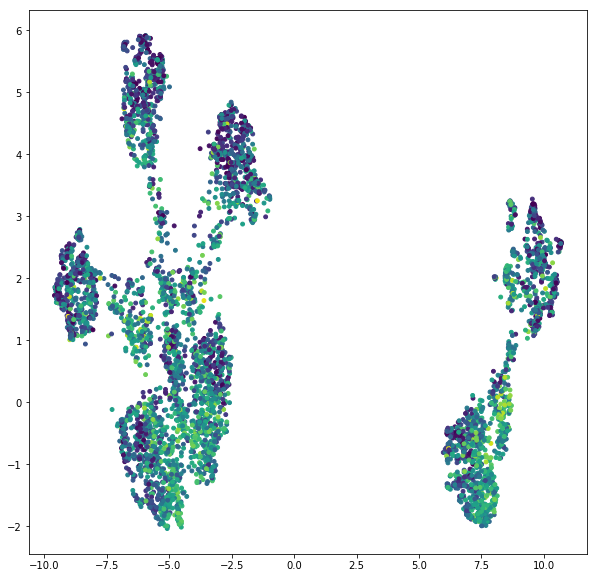

In [10]:
# impute the data to fill missing information
imputed_data = SimpleImputer().fit_transform(data_matrix[:-6])
trans_mat = UMAP(metric='hamming').fit_transform(imputed_data[:5000])

fig, ax = plt.subplots(1,1)
ax.scatter(trans_mat[:,0], trans_mat[:,1], c=data_matrix[:5000,0], s=15)
fig.set_size_inches(10,10)

<h1>Exploring Voter Turnout Differenes Between Clusters</h1>
<p>Interestingly, the distinct cluster on the left on average has a significantly higher turnout rate than that the cluster on the left for every recoreded general election.</p>

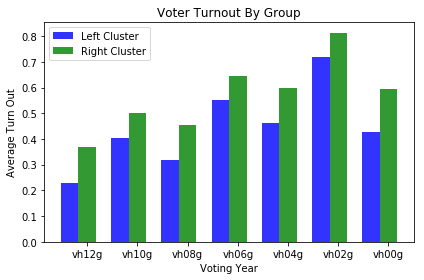

In [11]:
vote_hist = [
 'vh12g',
 'vh10g',
 'vh08g',
 'vh06g',
 'vh04g',
 'vh02g',
 'vh00g',]

selection_idx = trans_mat[:,0] > 2.5
right_cluster = voter_history[:5000][(selection_idx).astype(bool)].mean()
right_cluster = list(right_cluster)

left_cluster = voter_history[:5000][(1 - selection_idx).astype(bool)].mean()
left_cluster = list(left_cluster)

# create plot
fig, ax = plt.subplots()
index = np.arange(len(vote_hist))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, left_cluster, bar_width,
alpha=opacity,
color='b',
label='Left Cluster')

rects2 = plt.bar(index + bar_width, right_cluster, bar_width,
alpha=opacity,
color='g',
label='Right Cluster')

plt.xlabel('Voting Year')
plt.ylabel('Average Turn Out')
plt.title('Voter Turnout By Group')
plt.xticks(index + bar_width, vote_hist)
plt.legend()

plt.tight_layout()
plt.show()

<h1>Choosing a Target Value</h1>
<p>We are not given target values so we will have to make an assumption to describe the target value. Now we will average the voter turnout history for each sample. </p> 

In [12]:
X = df
X = X.values

num_rows = count_row = voter_history.shape[0]
Y = []
for i in range(num_rows):
    temp = list(voter_history.iloc[i])
    Y.append(mode(temp))

voter_history.head(5)
Y = voter_history.mean(axis=1)
Y.head(5)
Y = Y.values

for i in range(len(Y)):
    if Y[i] < .5:
        Y[i] = 0
    else:
        Y[i] = 1

<h1>Splitting the Dataset for Testing and Training</h1>

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(len(X_train), ' training samples')
print(len(X_test), 'validation samples')

40000  training samples
10000 validation samples


<h1>XGBoost for Binary Classification</h1>

In [14]:
# convert data into a format that can be used with XGBoost
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)
D = xgb.DMatrix(X, label=Y)

# defining the model and parameters
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 
steps = 20  # The number of training iterations
model = xgb.train(param, D_train, steps)

<h1>Predict Voter Turnout on Validation Data</h1>

In [15]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

Precision = 0.9981745419790777
Recall = 0.9982048456895879
Accuracy = 0.9982


In [16]:
# get turnout probability for each voter
plst = param.items()
bst = xgb.train(plst,D_train,)
ypred = bst.predict(D)
ypred = ypred[:,1]
ypred = list(ypred)

<h1>Add Predictions to Dataframe and Save Results to CSV</h1>

In [17]:
voter_file = 'data/voterfile/voterfile.csv'
df = pd.read_csv(voter_file)
df['vote_prob'] = ypred

# remove primary election turnout data 
for header in df.columns:
    if header[-1] == 'p':
        del df[header]

# save to CSV file
df.to_csv(r'./results.csv', index = None, header=True)
print('Results Saved!')

Results Saved!
